<a href="https://colab.research.google.com/github/atalsooraj/Multi-channel-Marketing-Spend-Optimization-using-Deep-Learning/blob/main/Data_Pre_processing_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
data_file = '/content/drive/MyDrive/606 Capstone/criteo_attribution_dataset.tsv.gz'

In [4]:
import pandas as pd
# df_Criteo_Attribution = pd.read_csv(DATA_FILE, sep='\t', compression='gzip')

df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

In [5]:
df0.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,0.000010,0.390794,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,0.000010,0.059600,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,0.000183,0.149706,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,0.000094,0.154785,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,0.000032,0.037583,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072


In [6]:
# df0[df0['uid']==7306395]

In [7]:
len(df0)

16468027

In [8]:
df0['campaign'].nunique()

675

In [9]:
df0['conversion'].value_counts()

0    15661831
1      806196
Name: conversion, dtype: int64

In [10]:
df = df0.copy()

In [11]:
del df0

Step 1: Creating a new column 'jid' by concatenating uid and conversion id. We do this becasue we want to analyze entire customer journeys i.e sequence of events.

In [12]:
#Concatenating uid and conversion_id since we want to analyze entire customer journeys(sequence of events)

df['jid']= df['uid'].map(str)+ '_'+df['conversion_id'].map(str)

Step 2: Scaling the timestamp column.

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
# Scaling timestamp and time_since_last_click columns 
minmaxscaler= MinMaxScaler()
for column in ('timestamp','time_since_last_click'):
  x= df[column].values.reshape(-1,1)
  df[column +'_norm']= minmaxscaler.fit_transform(x)


In [15]:
df['campaign'].nunique()

675

Step 3: Randomly sampling 200 campaigns.

In [16]:
#Randomly sampling 200 campaigns
import numpy as np
camapaigns_shortlisted= np.random.choice(df['campaign'].unique(),200,replace=False)
camapaigns_shortlisted[:5]

array([14458669, 14289571, 28031695, 23310435,  2077112])

Finding the set difference between original and shortlisted campaign id's. the result will give unwanted campaign id's.

In [17]:
not_reqd= np.setdiff1d(df['campaign'].values, camapaigns_shortlisted)


Considering all campaign id's except those present in not required array.

In [18]:
df = df[~df['campaign'].isin(not_reqd)]

In [19]:
len(df)

4910799

In [20]:
df['campaign'].nunique()

200

In [21]:
# df_sampled= df[df['campaign'][j for j in range(len(df['campaign']))]== [i for i in camapaigns_shortlisted]]

# df_sampled= df.loc[df['campaign'].apply(lambda x: x in camapaigns_shortlisted)]

#Source-https://stackoverflow.com/questions/21738882/fast-pandas-filtering

# df_sampled= df.loc[np.in1d(df['campaign'], camapaigns_shortlisted)]

Step 4: Counting the instances of each 'jid' and only considering theose journey id's having more than 1 occurence.

In [22]:
grouped= df.groupby(['jid'])['uid'].count().reset_index(name='count')

In [23]:
#grouped.head()

In [24]:
df2= df[df['jid'].isin(grouped[grouped['count'] >= 2]['jid'].values )]  #Only considering journey id's with more than 1 event. Here, we are indirectly removing jid's with only 1 occurence.

In [25]:
#df2.head()

In [26]:
del df
del not_reqd


In [27]:
len(df2)

3651171

In [28]:
df_0= df2[df2['conversion']==0]
df_1= df2[df2['conversion']==1]

In [29]:
len(df_0), len(df_1)

(3481839, 169332)

In [30]:
del df2

Step 5: Balancing the dataset: The number of convertd and non-converted events should be equal so that our model can have a balanced learning. We take all converted journeys and iteratively add non-converted events until the dataset is balanced. We do it this way because we want to balance the number of events but also want the whole journey.

In [31]:
df_0_jids= np.array_split(df_0['jid'].unique(),100* df_0.shape[0]/df_1.shape[0])

In [32]:
df_0_sampled = pd.DataFrame(data=None, columns=df_0.columns)

In [33]:
for array in df_0_jids:
  df_0_sampled = pd.concat([df_0_sampled, df_0[df_0.jid.isin(array)]])

  if df_0_sampled.shape[0]> df_1.shape[0]:
    break


In [34]:
df_final= pd.concat([df_0_sampled, df_1]).sample(frac=1).reset_index(drop=True)

In [35]:
del df_0,df_1,df_0_jids,df_0_sampled

In [36]:
df_final['conversion'].value_counts()

0    170217
1    169332
Name: conversion, dtype: int64

In [37]:
df_final.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm
0,124454,10730920,28795043,0,-1,-1,0,1,-1,-1,0.000014,0.279249,-1,30763035,9312274,23137544,29196072,32440044,1973606,1980833,29841067,29196072,10730920_-1,0.046591,0.000000
1,1772320,18294120,24942663,0,-1,-1,0,1,-1,-1,0.004622,0.301610,17577,27093701,9312274,23410096,29196072,20611409,30763035,13654477,29196072,15351053,18294120_-1,0.663492,0.006782
2,2062203,862538,28351001,1,2732225,7856566,0,1,13,16,0.000888,0.051292,396,25259032,9312274,23322867,29196072,5824236,29196072,16628728,29196072,16022563,862538_7856566,0.772014,0.000153
3,737323,16049029,7121544,0,-1,-1,0,0,-1,-1,0.000121,0.228472,-1,27093701,9312274,3495539,29196072,32440044,1973606,21147991,29841067,29196072,16049029_-1,0.276027,0.000000
4,1772819,15633986,15398570,1,1773056,30858709,1,1,12,13,0.000292,0.158713,88504,25259032,28928366,10787874,29196072,32440044,28928366,12289067,29196072,29520629,15633986_30858709,0.663679,0.034145


In [38]:
len(df_final)

339549

Finding unique values in each categorical column. Here, cat 7 has way too many features so we are going to ignore this columns and use all the others.

In [39]:
df_final[df_final.columns[13:22]].nunique()

cat1       9
cat2      46
cat3     511
cat4      17
cat5      39
cat6      30
cat7    5793
cat8      11
cat9      30
dtype: int64

Creating a dictionary with all unique categorical variables as keys and assigning them values based on length of the dictionary when they are added.

In [40]:
mapper= {}
col_names= ['cat1','cat2','cat3','cat4','cat5','cat6','cat8','cat9']
for i, col_name in enumerate(col_names):
  for val in df_final[col_name].unique():
    mapper[val*10 +i]=len(mapper)


Creating a new column containing the list of all the categories present in that corresponding rows.

In [41]:
df_ext = df_final.copy()
df_ext['cats']= df_ext[col_names].values.tolist()

In [42]:
df_ext.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats
0,124454,10730920,28795043,0,-1,-1,0,1,-1,-1,0.000014,0.279249,-1,30763035,9312274,23137544,29196072,32440044,1973606,1980833,29841067,29196072,10730920_-1,0.046591,0.000000,"[30763035, 9312274, 23137544, 29196072, 324400..."
1,1772320,18294120,24942663,0,-1,-1,0,1,-1,-1,0.004622,0.301610,17577,27093701,9312274,23410096,29196072,20611409,30763035,13654477,29196072,15351053,18294120_-1,0.663492,0.006782,"[27093701, 9312274, 23410096, 29196072, 206114..."
2,2062203,862538,28351001,1,2732225,7856566,0,1,13,16,0.000888,0.051292,396,25259032,9312274,23322867,29196072,5824236,29196072,16628728,29196072,16022563,862538_7856566,0.772014,0.000153,"[25259032, 9312274, 23322867, 29196072, 582423..."
3,737323,16049029,7121544,0,-1,-1,0,0,-1,-1,0.000121,0.228472,-1,27093701,9312274,3495539,29196072,32440044,1973606,21147991,29841067,29196072,16049029_-1,0.276027,0.000000,"[27093701, 9312274, 3495539, 29196072, 3244004..."
4,1772819,15633986,15398570,1,1773056,30858709,1,1,12,13,0.000292,0.158713,88504,25259032,28928366,10787874,29196072,32440044,28928366,12289067,29196072,29520629,15633986_30858709,0.663679,0.034145,"[25259032, 28928366, 10787874, 29196072, 32440..."


Creating a function to do one hot encoding for each row value in campaign's column and update the encoded value in an array.

In [43]:
def one_hot(values):
  v= np.zeros(len(mapper))
  for i, val in enumerate(values):
    mapped_val_id= mapper[val*10+i]
    v[mapped_val_id]= 1
  return v

In [44]:
import numpy as np

In [45]:
df_ext['cats']= df_ext['cats'].map(one_hot)

In [46]:
#df_ext['cats'][0]

Getting all unique values in the campaign column and creating a dictionary with keys as campaign id and values as the length of the dictionary.

In [47]:
mapper= {}
col_names= ['campaign']
for i, col_name in enumerate(col_names):
  for val in df_ext[col_name].unique():
    mapper[val*10 +i]=len(mapper)


df_ext['campaigns']= df_ext[col_names].values.tolist()



In [48]:
df_ext.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
0,124454,10730920,28795043,0,-1,-1,0,1,-1,-1,0.000014,0.279249,-1,30763035,9312274,23137544,29196072,32440044,1973606,1980833,29841067,29196072,10730920_-1,0.046591,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[28795043]
1,1772320,18294120,24942663,0,-1,-1,0,1,-1,-1,0.004622,0.301610,17577,27093701,9312274,23410096,29196072,20611409,30763035,13654477,29196072,15351053,18294120_-1,0.663492,0.006782,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[24942663]
2,2062203,862538,28351001,1,2732225,7856566,0,1,13,16,0.000888,0.051292,396,25259032,9312274,23322867,29196072,5824236,29196072,16628728,29196072,16022563,862538_7856566,0.772014,0.000153,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[28351001]
3,737323,16049029,7121544,0,-1,-1,0,0,-1,-1,0.000121,0.228472,-1,27093701,9312274,3495539,29196072,32440044,1973606,21147991,29841067,29196072,16049029_-1,0.276027,0.000000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[7121544]
4,1772819,15633986,15398570,1,1773056,30858709,1,1,12,13,0.000292,0.158713,88504,25259032,28928366,10787874,29196072,32440044,28928366,12289067,29196072,29520629,15633986_30858709,0.663679,0.034145,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[15398570]


using the one-hot function for campaign column.

In [49]:
df_ext['campaigns']= df_ext['campaigns'].map(one_hot)

Sorting the obtained dataframe by normalized timestamp value.

In [50]:
df_model= df_ext.sort_values(by=['timestamp_norm'])

In [51]:
df_model.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
49676,2,28474333,18975823,0,-1,-1,0,0,-1,-1,0.000183,0.149706,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056,28474333_-1,7.487274e-07,0.003426,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
130369,3,25357769,13365547,0,-1,-1,0,0,-1,-1,0.000032,0.037583,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072,25357769_-1,1.123091e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
235598,4,19923387,31772643,0,-1,-1,0,0,-1,-1,0.000035,0.087070,179666,30763035,9312274,5028397,29196072,32440044,32440041,14074087,29196072,21091108,19923387_-1,1.497455e-06,0.069316,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
37583,4,93907,17686799,0,-1,-1,0,1,-1,-1,0.000186,0.267100,262565,30763035,9068207,9107790,29196072,32440044,1973606,2687461,29841067,21091108,93907_-1,1.497455e-06,0.101299,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
313193,12,28883743,24267774,0,-1,-1,0,1,-1,-1,0.000010,0.051985,-1,138937,9312274,21728809,29196072,3808271,28928366,9312274,29196072,29196072,28883743_-1,4.492365e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [52]:
# df_model['campaigns'][94389]

In [53]:
journey_counts= df_model.groupby(['jid'])['uid'].count().reset_index(name='count').groupby(['count']).count()
counts= journey_counts.index
no_of_jids= journey_counts.values 

In [54]:
import matplotlib.pyplot as plt

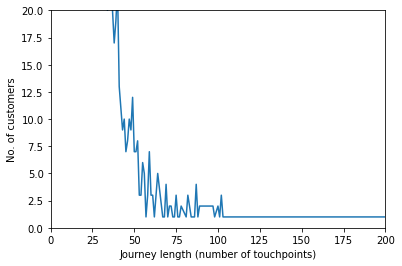

In [55]:
plt.plot(counts,no_of_jids)
plt.ylim(0,20)
plt.xlim(0,200)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('No. of customers')
plt.show()

From the above plot, it is clear that as the journey lenght increases, the number of jid's is decreasing. This is expected and makes sense. This re-affirms that we can develop a model for sequential data.

Counting the number of events for each campaign_id

In [56]:
counters= np.zeros(200)
for campaign_one_hot in df_model['campaigns'].values:
  campaign_id= np.argmax(campaign_one_hot)
  counters[campaign_id]= counters[campaign_id]+1


In [57]:
# counters

To understand what counters represents, let us consider the first row from df_modelhaving an index 94389. When we apply the argmax function to an encoded array like in our case to the campaigns array, we get the position of value 1 in the encoded campaigns array i.e 86 here. Intitially, counters[86] will be 0(since we added 200 zeros). When a campaign's value in the encoded array is 86, it will increase the value of counter[86] by 1 and hence giving us the total number of occurences of a campaign in the entire dataset. So, now if we check the value of counters[86] we will get the count of the campaign 884761 which is 1368. So there are 1368 instances of the campaign 884761.

In [58]:
np.argmax(df_model['campaigns'][94389])

60

In [59]:
counters[86]

2714.0

In [60]:
df_converted= df_model[df_model['conversion']==1]

In [61]:
# df_converted.head()

In [62]:
len(df_converted)

169332

In [63]:
df_converted['jid'].nunique()

44314

Counting the number of times a given campaign is the last touch before the conversion. here, when we groupby jid and timestamp_norm, we get 2 columns. One column is jid containing jid's  and the other containing the corresponding timestamp_norm value for the event. There may be multiple instances of jid's having multiple values of timestamp_norm values. The transform(max) function gives us the maximum value of timestamp_norm from among this sample of jid's. Finally, we check if this obtained max value is equal to the value in timestamp_norm column i.e if this was the last event and return a boolean value of either true or False along with the index value of timestamp_norm.

In [64]:
index= df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']

In [65]:
index[:5]

330646    False
145343    False
248616    False
95779     False
88194     False
Name: timestamp_norm, dtype: bool

In [66]:
len(index.tolist())

169332

Taking all last touch arrays from campaigns column based on index of True values.

In [67]:
# df_converted[index]['campaigns']

As done before, counting the number of times the event was last touch before conversion.

In [68]:
counters_2= np.zeros(200)
for campaign_one_hot in df_converted[index]['campaigns'].values:
  campaign_id= np.argmax(campaign_one_hot)
  counters_2[campaign_id]= counters_2[campaign_id]+1

Now, we have obtained the number of occurences for a campaign (counters) and number of times that campaign was last touch(counters). The ratio between the number of journeys in which a given campaign is the last event and the total number of events for the same campaign gives us the attribution weight (which is return per impression).

In [69]:
attributions= counters_2/counters

Text(0, 0.5, 'Return per impression (attribution)')

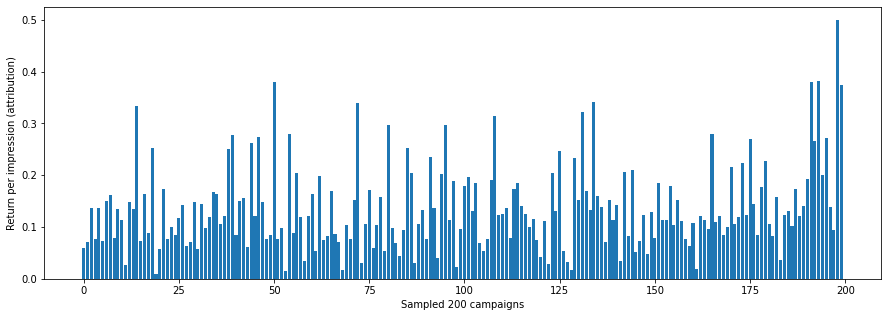

In [70]:
campaign_idx= range(0,200)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
plt.bar( range(len(attributions[campaign_idx])), attributions[campaign_idx], label='LTA' )
plt.xlabel('Sampled 200 campaigns')
plt.ylabel('Return per impression (attribution)')

In [71]:
del camapaigns_shortlisted, data_file, df_converted, df_ext, df_final, index, mapper, minmaxscaler, one_hot

In [72]:
del attributions

In [73]:
 del campaign_id,campaign_idx, campaign_one_hot, col_name, col_names, column, counters, counters_2, counts,grouped, i, journey_counts, no_of_jids

In [74]:
# df_model.to_csv('Dataframe_test.csv',sep)

In [75]:
# def features_for_logistic_regression(df):

#     def pairwise_max(series):
#         return np.max(series.tolist(), axis = 0).tolist()
    
#     aggregation = {                      # aggregation specification for each feature
#         'campaigns': pairwise_max,
#         'cats': pairwise_max,
#         'click': 'sum',
#         'cost': 'sum',
#         'conversion': 'max'
#     }
    
#     df_agg = df.groupby(['jid']).agg(aggregation)
    
#     df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
#     return (
#         np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
#         df_agg['conversion'].values
#     )



In [76]:
# x,y = features_for_logistic_regression(df_model)
# print(np.shape(x))

In [77]:
# from sklearn.model_selection import train_test_split